先生より
>線形予測フィルタでのイノベーションの推定があまり良くない原因は，ARの係数推定の不安定性だと思います．何法で推定するにしても係数の推定は回帰分析と等価なので，データの共線性が問題になります．その意味でAR系列は明らかに不利です．これは実験的にも確認できると思いますので，係数の分布とかを確認しておいて下さい(シミュレーション+面倒な理論はあるので余力があれば)．実データの場合にはモデルの不一致の問題などもあるので，理論通りにはいきませんが，そこはsieve bootstrap のような方法が使えます．(ここまでは係数の推定量の分布を調べるということ)<br>
このあたりを整理して，線形予測による残差でのinnovationの推定の限界を評価しておいて下さい．(こちらは係数の推定量の分布から算出される各点での残差の分布を調べ，更に全点での残差の分布も調べるということ)

こいつを確かめにゃならん！

1. 学習データの数によって最尤推定量がどのくらいばらつくのかをみたい（seedを変えていくつもデータセットを作成する必要がある）
2. 一つのデータをbootで増やして推定量の分布を確かめるとどうなるんだろう？（これは実践を踏まえて）
3. モデルが違ってしまっている場合(ARならpが異なるなど)は推定量の分布はどうなるのだろう？


4. 現在時刻の値と過去$p$時刻の値を用いて推定するinnovationの分布の方も気になる<br>
パラメタの推定量が分布として与えられるならば、ある時刻における時系列の実現値がgivenの時のinnovationの推定量の分布がわかるはず！

やること

1. ARモデルに従うデータを一つ作る<br>
$p=7$, $\alpha=[0.3,-0.4,0.2,-0.5,0.6,-0.1,0.1]$, $\sigma=2$, $N=1400$
2. データ数によって最尤推定量がどのくらいばらつくのかをみたい

### いつもの

In [17]:
import argparse
import os
path = os.getcwd()
path=path[:path.find('timeseries-WGAN')+15]
import numpy as np
from scipy import stats
import math
import sys
sys.path.append(path+"/")
import random
import statsmodels.api as sm
from scipy.stats import norm

import torchvision.transforms as transforms
from torchvision.utils import save_image

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable

# 人工データを生成してくれる機械が置いてあるところ
import tsModel
# 学習用のニューラルネットが置いてあるところ
import models
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
import japanize_matplotlib
from scipy.stats import gaussian_kde

##### ヒストグラム や分布をカーネル密度推定した図を保存するフォルダを作らねば...

In [2]:
os.makedirs("distribution-images", exist_ok=True)

### データの作成

やること

1. ARモデルに従うデータを一つ作る<br>
$p=7$, $\alpha=[0.3,-0.4,0.2,-0.5,0.6,-0.1,0.1]$, $\sigma=2$, $N=1400$

In [3]:
alpha=[0.3,-0.4,0.2,-0.5,0.6,-0.1,0.1]
p=len(alpha)
sigma=2

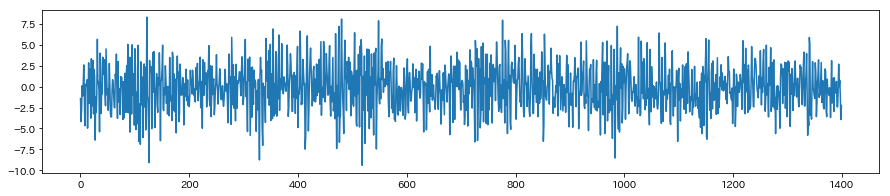

In [4]:
# 人工データの作成
seed=10
Data = tsModel.SARIMA(a=alpha, N=1400, random_seed=seed, sigma=sigma)
plt.figure(figsize=(15,3))
plt.plot(Data)

## まずは学習データの数によってどのくらい推定量がばらつくのかを実験的に確かめる

学習データ数を固定し、データ生成のseedを変化させることで係数の推定にブレ幅を持たせる

モデルの次数も変化させてみる

### まずは
$N=1000$ <br>
データのindexは0~99の100個<br>
推定時の次数pは1~10

In [69]:
N=1000
n=100
data_index = range(n)

#### $\hat p=7$　　　(正しい)

In [94]:
hat_p=7

In [95]:
results = []
results_sigma = []
for seed in data_index:
    Data = tsModel.SARIMA(a=alpha, N=N, random_seed=seed, sigma=sigma)
    
    
    # モデルのハイパラの決定
    # hat_p=7
    
    # モデルの学習
    model = sm.tsa.AR(Data)
    result = model.fit(maxlag=hat_p)
    results.append(result.params)
    results_sigma.append(np.sqrt(result.sigma2))

results = np.array(results)
results_sigma = np.array(results_sigma)

#### $\hat a_i^{\hat p}$の分布をみる

bin幅：$\sqrt{n}$

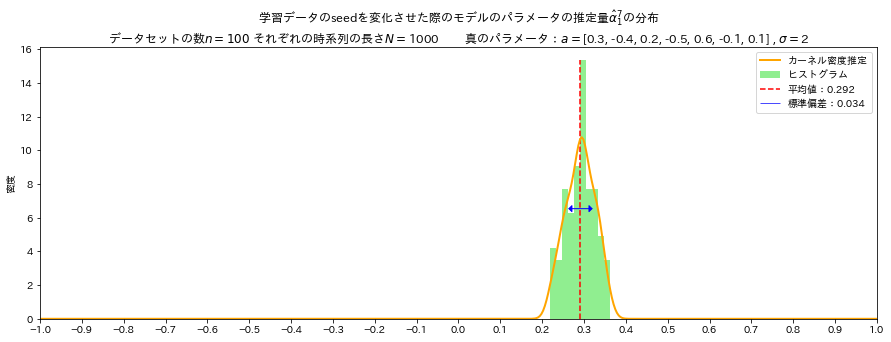

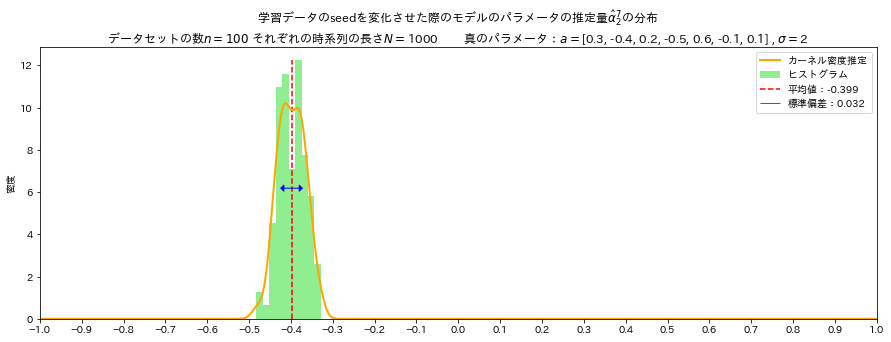

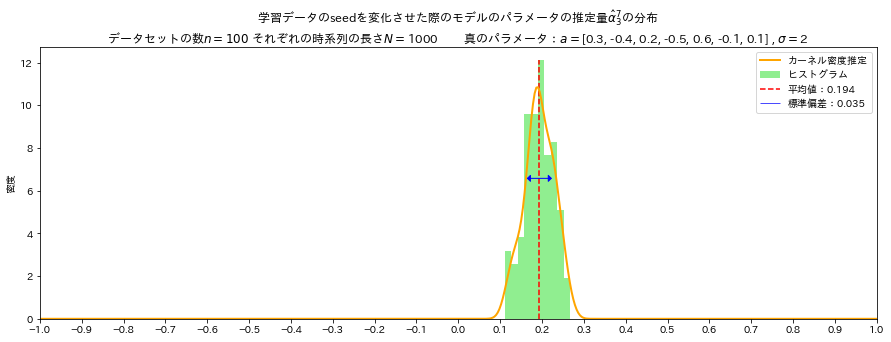

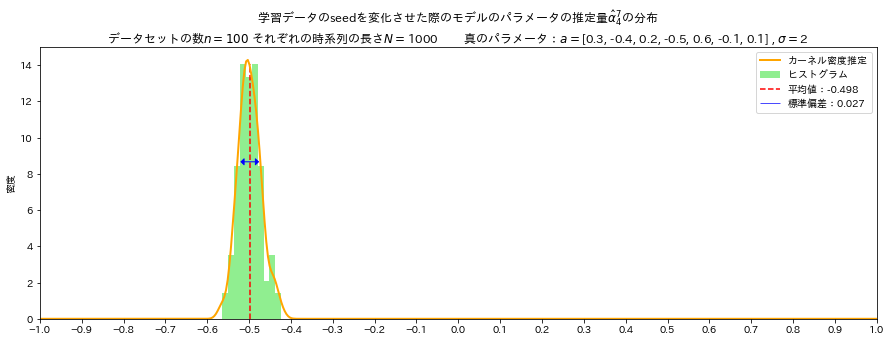

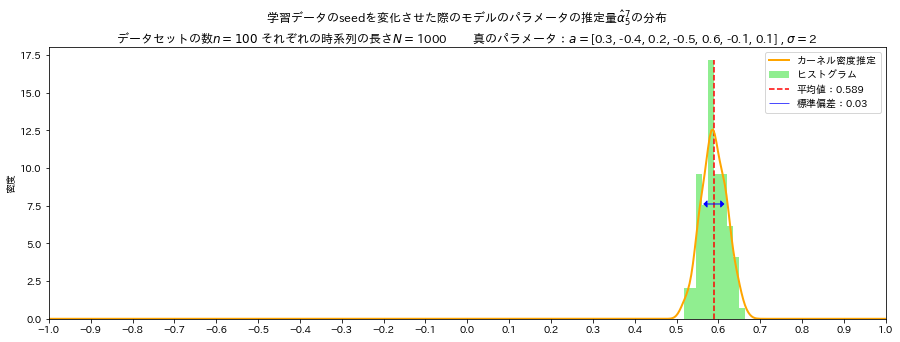

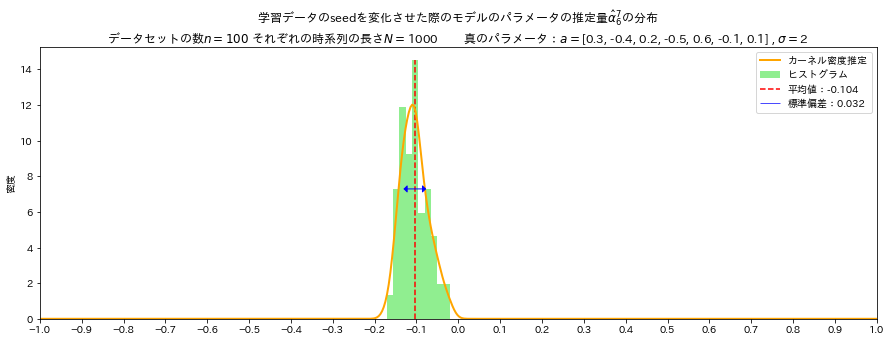

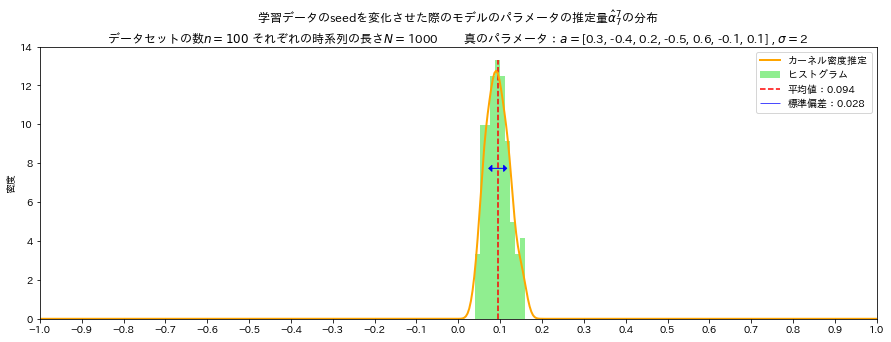

In [142]:
for i in range(1,hat_p+1):
    plt.figure(figsize=(15,5))
    ret=plt.hist(results[:,i], bins=int(np.sqrt(n)), density=True, label="ヒストグラム ", color="lightgreen")
    plt.xticks(np.arange(-1, 1.1, 0.1))
    plt.xlim(-1,1)
    plt.title("学習データのseedを変化させた際のモデルのパラメータの推定量$\hat {\\alpha}^"+str(hat_p)+"_"+str(i)+"$の分布\nデータセットの数$n="+str(n)+"$ それぞれの時系列の長さ$N=$"+str(N)+"        真のパラメータ：$a=$"+str(alpha)+" , $\sigma=$"+str(sigma))
    plt.ylabel("密度")
    kde = gaussian_kde(results[:,i])
    ls = np.linspace(-1, 1 , 500)
    kde = kde.pdf(ls)
    plt.plot(ls, kde , label="カーネル密度推定",linewidth=2, color="orange")
    mean=results[:,i].mean()
    std=results[:,i].std()
    plt.vlines(mean, 0, max(ret[0]), "red", linestyles='dashed', label="平均値："+str(round(mean, 3)))
    plt.vlines(0,0,0,"blue",label="標準偏差："+str(round(std, 3)), linewidth=0.7)
    plt.annotate('', xy=(mean-std, max(kde)*np.exp(-0.5)), xytext=(mean+std, max(kde)*np.exp(-0.5)),
                arrowprops=dict(arrowstyle=ArrowStyle('<|-|>', head_length=0.3, head_width=0.3),# 矢頭の長さと幅の設定
                                facecolor='blue',
                                edgecolor='blue'
                               )
                )
    plt.legend()
    plt.savefig("distribution-images/a{0}_{1}__N{2}.png".format(hat_p, i, N))


#### $\hat \mu^{\hat p}$の分布をみる

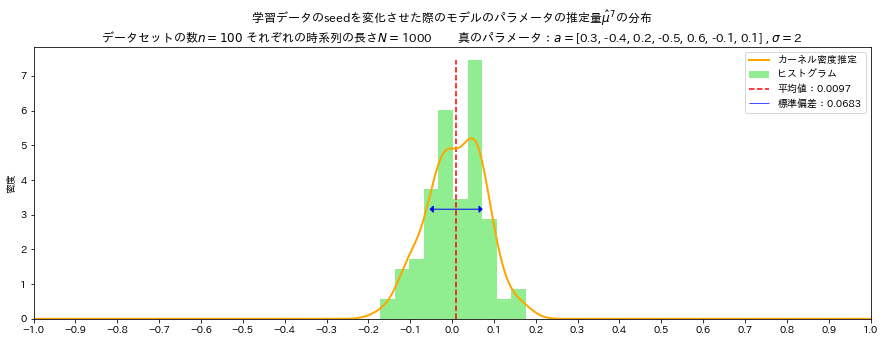

In [140]:
i=0
plt.figure(figsize=(15,5))
ret=plt.hist(results[:,i], bins=int(np.sqrt(n)), density=True, label="ヒストグラム ", color="lightgreen")
plt.xticks(np.arange(-1, 1.1, 0.1))
plt.xlim(-1,1)
plt.title("学習データのseedを変化させた際のモデルのパラメータの推定量$\hat {\mu}^"+str(hat_p)+"$の分布\nデータセットの数$n="+str(n)+"$ それぞれの時系列の長さ$N=$"+str(N)+"        真のパラメータ：$a=$"+str(alpha)+" , $\sigma=$"+str(sigma))
plt.ylabel("密度")
kde = gaussian_kde(results[:,i])
ls = np.linspace(-1, 1 , 500)
kde = kde.pdf(ls)
plt.plot(ls, kde , label="カーネル密度推定",linewidth=2, color="orange")
mean=results[:,i].mean()
std=results[:,i].std()
plt.vlines(mean, 0, max(ret[0]), "red", linestyles='dashed', label="平均値："+str(round(mean, 4)))
plt.vlines(0,0,0,"blue",label="標準偏差："+str(round(std, 4)), linewidth=0.7)
plt.annotate('', xy=(mean-std, max(kde)*np.exp(-0.5)), xytext=(mean+std, max(kde)*np.exp(-0.5)),
            arrowprops=dict(arrowstyle=ArrowStyle('<|-|>', head_length=0.3, head_width=0.3),# 矢頭の長さと幅の設定
                            facecolor='blue',
                            edgecolor='blue'
                           )
            )
plt.legend()
plt.savefig("distribution-images/mu{0}__N{1}.png".format(hat_p, N))

#### $\hat \sigma_{\hat p}$の分布をみる

In [135]:
max(kde)*np.exp(-0.5)

5.466206211538804

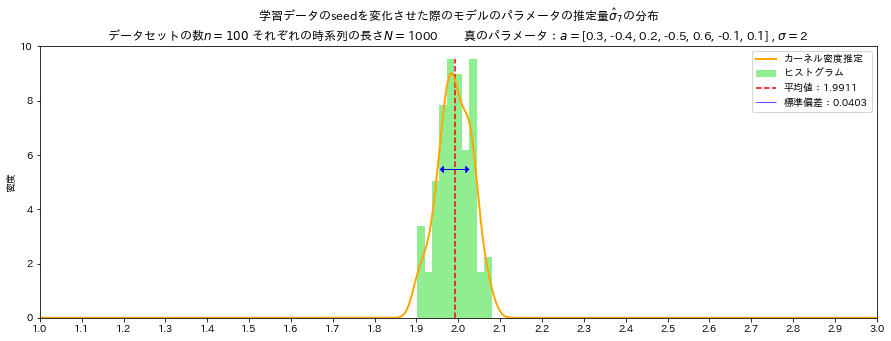

In [136]:
plt.figure(figsize=(15,5))
ret=plt.hist(results_sigma, bins=int(np.sqrt(n)), density=True, label="ヒストグラム ", color="lightgreen")
plt.xticks(np.arange(sigma-1, sigma+1.1, 0.1))
plt.xlim(sigma-1,sigma+1)
plt.title("学習データのseedを変化させた際のモデルのパラメータの推定量$\hat {\sigma}_"+str(hat_p)+"$の分布\nデータセットの数$n="+str(n)+"$ それぞれの時系列の長さ$N=$"+str(N)+"        真のパラメータ：$a=$"+str(alpha)+" , $\sigma=$"+str(sigma))
plt.ylabel("密度")
kde = gaussian_kde(results_sigma)
ls=np.linspace(sigma-1, sigma+1 , 500)
kde = kde.pdf(ls)
plt.plot(ls, kde , label="カーネル密度推定",linewidth=2, color="orange")
mean=results_sigma.mean()
std=results_sigma.std()
plt.vlines(mean, 0, max(ret[0]), "red", linestyles='dashed', label="平均値："+str(round(mean, 4)))
plt.vlines(0,0,0,"blue",label="標準偏差："+str(round(std, 4)), linewidth=0.7)
plt.annotate('', xy=(mean-std, max(kde)*np.exp(-0.5)), xytext=(mean+std, max(kde)*np.exp(-0.5)),
            arrowprops=dict(arrowstyle=ArrowStyle('<|-|>', head_length=0.3, head_width=0.3),# 矢頭の長さと幅の設定
                            facecolor='blue',
                            edgecolor='blue'
                           )
            )
plt.legend()
plt.savefig("distribution-images/sigma{0}__N{1}.png".format(hat_p, N))

#### ある時刻におけるinnovtionの推定量の分布をみる

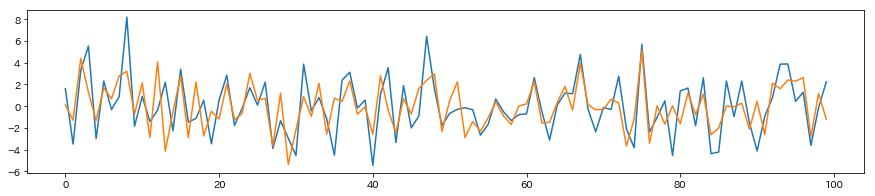

In [162]:
# まずはある時系列を作る（訓練データと生成モデルは同じ）
seed=2**32 - 1
testData = tsModel.SARIMA(a=alpha, N=100, random_seed=seed, sigma=sigma)
plt.figure(figsize=(15,3))
plt.plot(testData)

eps = tsModel.SARIMA(a=alpha, N=100, random_seed=seed, sigma=sigma, return_innovation=True)
plt.plot(eps)

$\hat\varepsilon_t=X_t-\hat\mu-\sum_{i=1}^{\hat p}\hat\alpha^{\hat p}_iX_{t-i}$

In [172]:
def hat_eps(t, results, testData):
    '''
    $\hat\\varepsilon_t=X_t-\hat\mu-\sum_{i=1}^{\hat p}\hat\\alpha^{\hat p}_iX_{t-i}$を分布として返す
    resultsはモデルのパラメータの推定量の分布
    testDataは検証に用いる時系列データ
    '''
    end=t# tに相当する
    start=end-hat_p
    ret= testData[end] - results[:,1] - (np.flip(testData[start:end])*results[:,1:]).sum(axis=1)
    return ret

In [169]:
hat_eps(10, results=results, testData=testData)

array([1.702905  , 2.04915591, 2.21023424, 2.06965699, 1.94657099,
       1.71130297, 2.02858376, 1.89323331, 1.92002115, 1.97519216,
       1.57753696, 1.66883049, 1.8049019 , 1.77133414, 1.62644421,
       1.99313846, 1.85159711, 1.60240184, 2.52437683, 2.08051613,
       1.80834572, 1.61428463, 2.26286149, 1.75759009, 1.9937364 ,
       2.27476868, 2.05371   , 1.69016885, 1.95560299, 2.09331491,
       1.94164722, 1.55780727, 2.00456269, 1.64756187, 1.33703249,
       1.75064818, 1.50776133, 1.54165996, 1.69573307, 1.66664471,
       2.29261784, 2.05224702, 1.8596112 , 1.99581452, 2.0005183 ,
       1.74205089, 1.91312448, 1.73430263, 1.85357294, 1.8702385 ,
       1.87761218, 2.00738778, 1.82576721, 1.60280986, 1.96600957,
       1.785649  , 1.98945772, 2.13101902, 1.89131046, 1.78102628,
       1.78562025, 1.96511525, 2.43480171, 1.37279632, 1.81264671,
       2.15850954, 2.02406903, 2.0240957 , 2.29054454, 1.63752199,
       1.69650866, 2.27510468, 1.96962526, 1.86363705, 1.70102

In [ ]:
plt.fill_between(x_pred, lower, upper,　color='#888888', alpha=0.4)

#### $\hat p=6$

In [76]:
hat_p=6

In [77]:
results = []
results_sigma = []
for seed in data_index:
    Data = tsModel.SARIMA(a=alpha, N=N, random_seed=seed, sigma=sigma)
    
    
    # モデルのハイパラの決定
    # hat_p=7
    
    # モデルの学習
    model = sm.tsa.AR(Data)
    result = model.fit(maxlag=hat_p)
    results.append(result.params)
    results_sigma.append(result.sigma2)

results = np.array(results)
results_sigma = np.array(results_sigma)

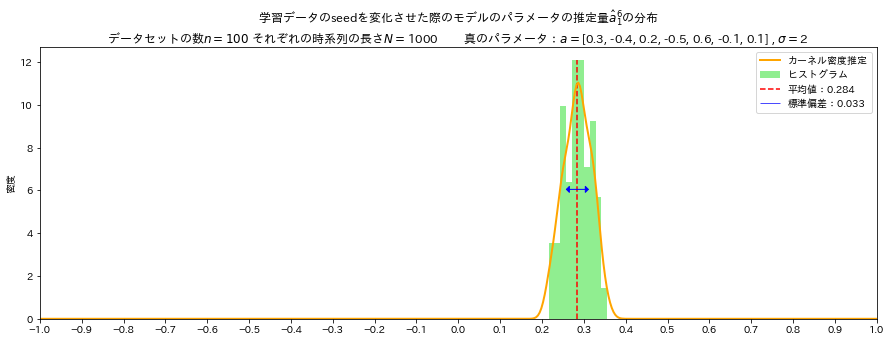

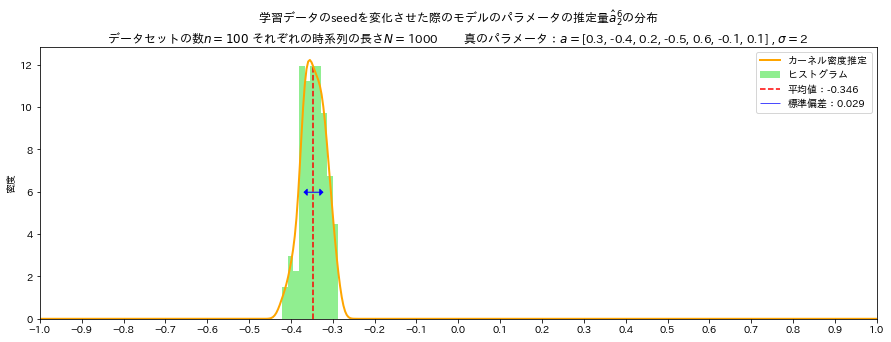

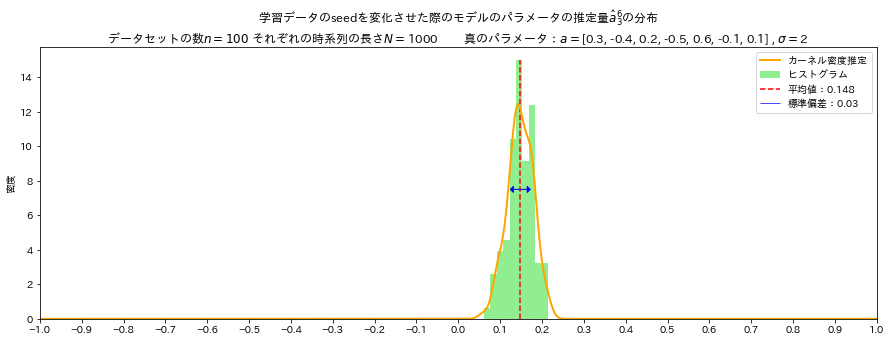

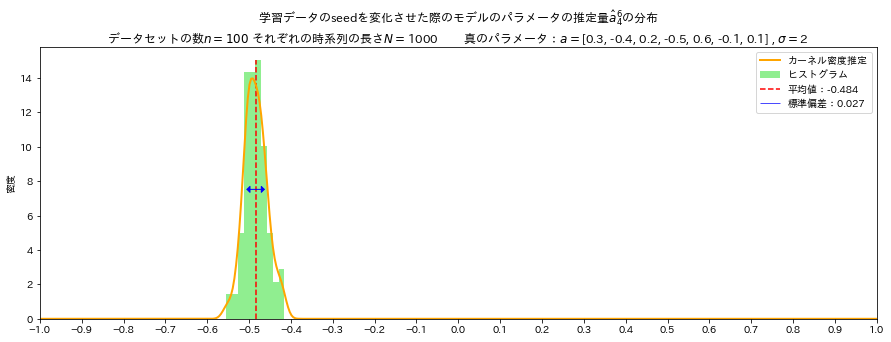

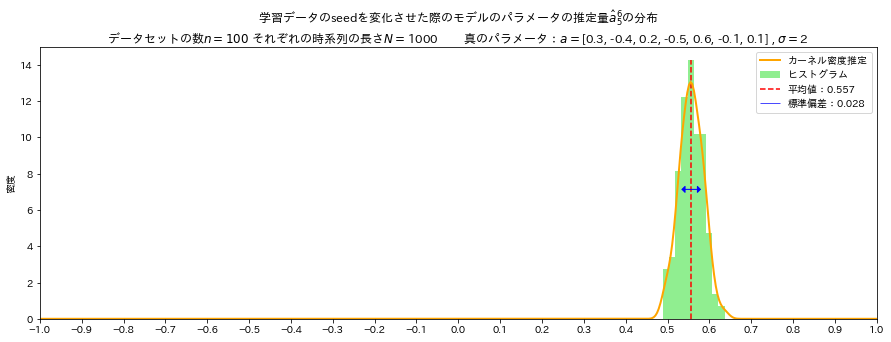

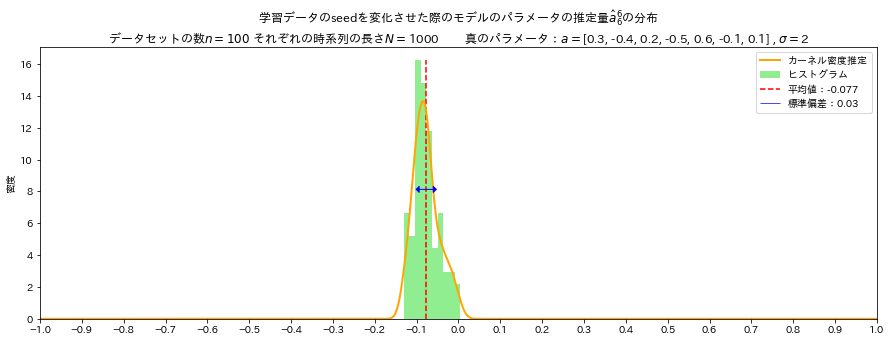

In [79]:
for i in range(1,hat_p+1):
    plt.figure(figsize=(15,5))
    ret=plt.hist(results[:,i], bins=int(np.sqrt(n)), density=True, label="ヒストグラム ", color="lightgreen")
    plt.xticks(np.arange(-1, 1.1, 0.1))
    plt.xlim(-1,1)
    plt.title("学習データのseedを変化させた際のモデルのパラメータの推定量$\hat a^"+str(hat_p)+"_"+str(i)+"$の分布\nデータセットの数$n="+str(n)+"$ それぞれの時系列の長さ$N=$"+str(N)+"        真のパラメータ：$a=$"+str(alpha)+" , $\sigma=$"+str(sigma))
    plt.ylabel("密度")
    kde = gaussian_kde(results[:,i])
    ls = np.linspace(-1, 1 , 500)
    plt.plot(ls, kde.pdf(ls) , label="カーネル密度推定",linewidth=2, color="orange")
    mean=results[:,i].mean()
    std=results[:,i].std()
    plt.vlines(mean, 0, max(ret[0]), "red", linestyles='dashed', label="平均値："+str(round(mean, 3)))
    plt.vlines(0,0,0,"blue",label="標準偏差："+str(round(std, 3)), linewidth=0.7)
    plt.annotate('', xy=(mean-std, max(ret[0])/2), xytext=(mean+std, max(ret[0])/2),
                arrowprops=dict(arrowstyle=ArrowStyle('<|-|>', head_length=0.3, head_width=0.3),# 矢頭の長さと幅の設定
                                facecolor='blue',
                                edgecolor='blue'
                               )
                )
    plt.legend()
    plt.savefig("distribution-images/a{0}_{1}__N{2}.png".format(hat_p, i, N))


#### $\hat p=5$

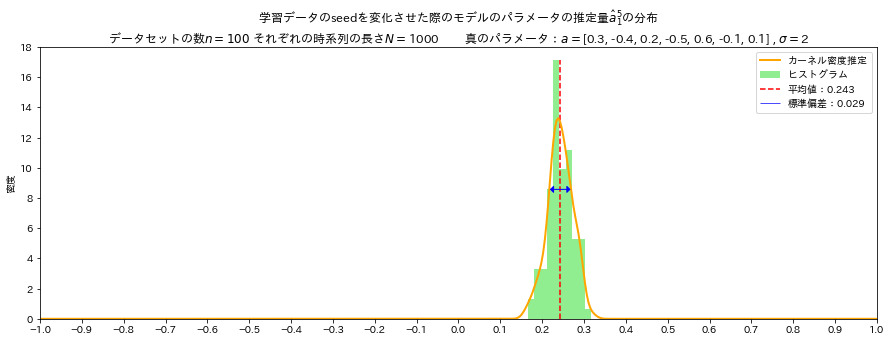

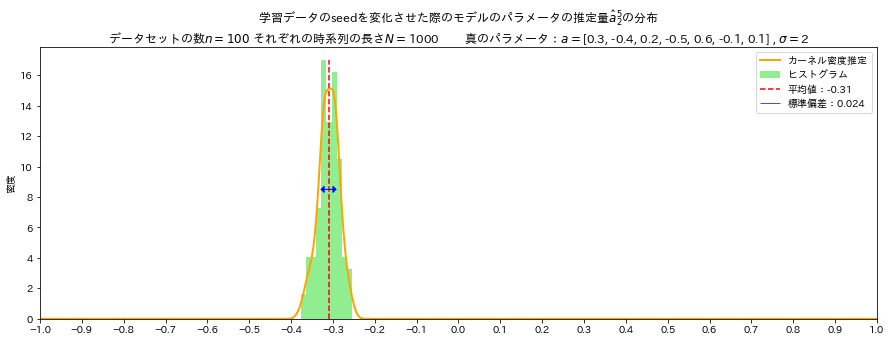

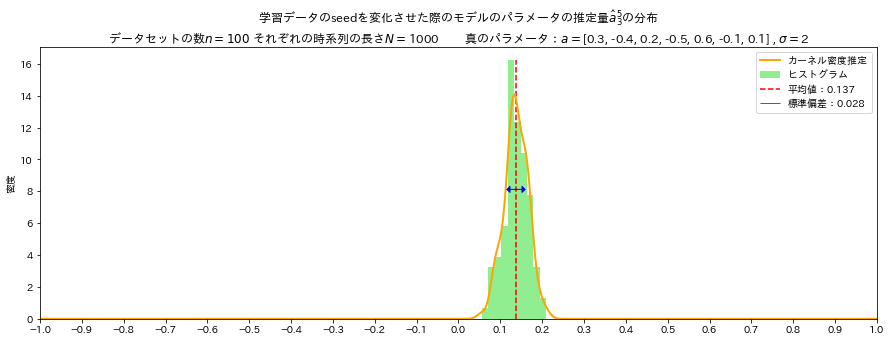

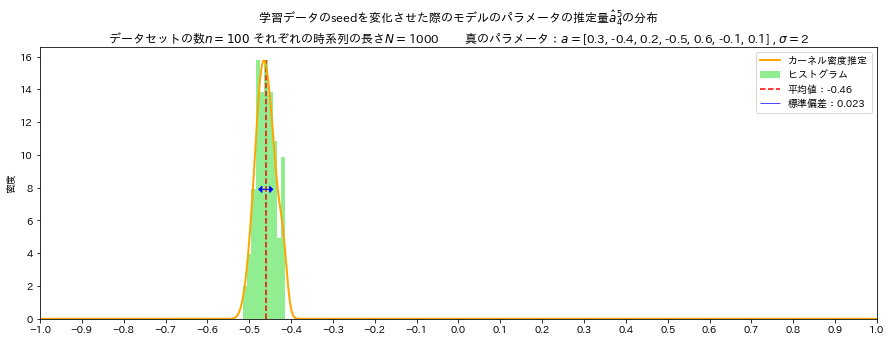

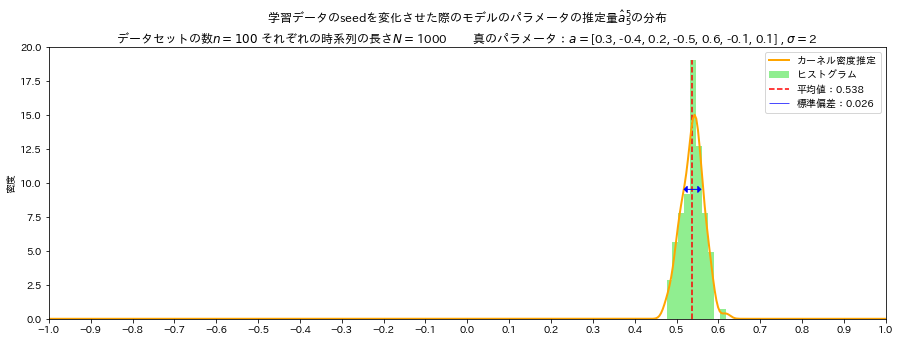

In [80]:
hat_p=5

results = []
results_sigma = []
for seed in data_index:
    Data = tsModel.SARIMA(a=alpha, N=N, random_seed=seed, sigma=sigma)
    # モデルのハイパラの決定
    # hat_p=7
    # モデルの学習
    model = sm.tsa.AR(Data)
    result = model.fit(maxlag=hat_p)
    results.append(result.params)
    results_sigma.append(result.sigma2)
results = np.array(results)
results_sigma = np.array(results_sigma)

for i in range(1,hat_p+1):
    plt.figure(figsize=(15,5))
    ret=plt.hist(results[:,i], bins=int(np.sqrt(n)), density=True, label="ヒストグラム ", color="lightgreen")
    plt.xticks(np.arange(-1, 1.1, 0.1))
    plt.xlim(-1,1)
    plt.title("学習データのseedを変化させた際のモデルのパラメータの推定量$\hat a^"+str(hat_p)+"_"+str(i)+"$の分布\nデータセットの数$n="+str(n)+"$ それぞれの時系列の長さ$N=$"+str(N)+"        真のパラメータ：$a=$"+str(alpha)+" , $\sigma=$"+str(sigma))
    plt.ylabel("密度")
    kde = gaussian_kde(results[:,i])
    ls = np.linspace(-1, 1 , 500)
    plt.plot(ls, kde.pdf(ls) , label="カーネル密度推定",linewidth=2, color="orange")
    mean=results[:,i].mean()
    std=results[:,i].std()
    plt.vlines(mean, 0, max(ret[0]), "red", linestyles='dashed', label="平均値："+str(round(mean, 3)))
    plt.vlines(0,0,0,"blue",label="標準偏差："+str(round(std, 3)), linewidth=0.7)
    plt.annotate('', xy=(mean-std, max(ret[0])/2), xytext=(mean+std, max(ret[0])/2),
                arrowprops=dict(arrowstyle=ArrowStyle('<|-|>', head_length=0.3, head_width=0.3),# 矢頭の長さと幅の設定
                                facecolor='blue',
                                edgecolor='blue'
                               )
                )
    plt.legend()
    plt.savefig("distribution-images/a{0}_{1}__N{2}.png".format(hat_p, i, N))
